## Import Libraries

In [46]:
import jax
import jax.numpy as jnp
import immrax as irx
from scipy.interpolate import interp1d
import numpy as np
from scipy.io import loadmat

## Load Data

In [47]:
# Control Data
data = loadmat('export_for_verification/data1.mat')
T_des = data['T_brk'][0]
U_des = data['U_brk']
Z_des = data['Z_brk']


# Obstacle Data
obstacle = loadmat('export_for_verification/obs1.mat')
O = obstacle['O']
O_buf = obstacle['O_buf']
O_pts = obstacle['O_pts']


## Define Helper Functions

In [48]:
def saturate_input(u):
    turtlebot_max_yaw_rate = 2.0 # rad/s
    turtlebot_max_accel = 2.0 # m/s^2

    min_rate = -turtlebot_max_yaw_rate
    max_rate = turtlebot_max_yaw_rate
    min_accel = -turtlebot_max_accel
    max_accel = turtlebot_max_accel


    mins = jnp.array([min_rate, min_accel])
    maxs = jnp.array([max_rate, max_accel])

    return jnp.clip(u, mins, maxs)


def rotation_matrix_2D(theta):
    return jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                      [jnp.sin(theta), jnp.cos(theta)]])


def match_trajectories(T_des, *varargin):
    interp_mode = varargin[-1]
    interp_type = interp_mode if interp_mode is not None else 'linear'
    # T_des = varargin[0]
    T_des = np.array([T_des])
    # print(f"T_des: {T_des}")

    output = []
    out_idx = 1
    for idx in range(0,4,2):
        # get the current time and trajectory
        T = varargin[idx]
        # print('here')
        # print(T)
        Z = varargin[idx+1]
        
        # if T_des exceeds the bounds of T, pad T and Z accordingly
        if T_des[0] < T[0]:
            T = [T_des(0), T]
            Z = [Z[:,0], Z]
            # print('here1')
        
        if T_des[-1] > T[-1]:
            T = [T, T_des[-1]]
            Z = [Z, Z[:,-1]]
            # print('here2')
        

        if len(T) == 1 and T_des == T:
            # check if no interpolation is needed (this resolves a bug
            # where interp1 reinterprets the length of Z as a vector to be
            # interpolated, and throws an error because T and Z are not of
            # the same length)
            output[out_idx] = Z
        else:
            # call interp1 as usual
            x = T
            y = Z
            # print(f"x: {x}")
            # print(f"y: {y}")
            f = interp1d(x, y, kind=interp_type)
            x_new = T_des
            # print(f"x_new: {x_new}")
            y_new = f(x_new)
            # print(f"y_new: {y_new.shape}")

            output.append(y_new)
            # print(f"output: {output}")

    return output


In [49]:
def get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des):
    # define gains
    k_p = 9
    k_v = 12
    k_a = 1
    k_h = 1
    k_w = 1
    k_hp = 0
    
    # define parameters
    t_lkhd = 0.01
    t_fdbk = min(t_curr + t_lkhd, T_des[-1])
    # print(f"t_curr: {t_curr}")
    # print(f"t_lkhd: {t_lkhd}")
    # print(f"T_des[-1]: {T_des[-1]}")
    # print(f"t_fdbk: {t_fdbk}")

    # get current state
    p_cur = z_curr[0:2]
    h_cur = z_curr[2]
    v_cur = z_curr[3]
    # print(f"p_cur: {p_cur.shape}")

    # get desired state and inputs (assumes zero-order hold)
    # we are doing feedback about a desired trajectory
    [u_des, z_des] = match_trajectories(t_fdbk, T_des, U_des, T_des, Z_des, 'previous')
    p_des = z_des[0:2]
    v_des = z_des[3]
    h_des = z_des[2]
    # print(f"p_des: {p_des}")
    # print(f"v_des: {v_des}")
    # print(f"h_des: {h_des}")
    # print(f"u_des: {u_des}")
    # print(f"z_des: {z_des}")
    # print(f"z_des: {z_des.shape}")

    # get desired feedforward inputs
    w_des = u_des[0]
    a_des = u_des[1]


    # compute position error in heading direction
    # print(f"h_cur: {h_cur.shape}")
    # print(f"h_cur: {h_cur}")
    R = rotation_matrix_2D(h_cur[0])

    # print(f"R.shape: {R.shape}")
    x = p_des - p_cur
    # print(f"p_des: {p_des.shape}")
    # print(f"p_cur: {p_cur.shape}")
    # print(f"x: {x.shape}")


    p_err = R@x
    # print(f"p_err: {p_err.shape}")
    px_err = p_err[0]
    
    # compute heading relative to desired position
    hp_err = -jnp.atan2(p_err[1],p_err[0])


    # compute unsaturated inputs (they get saturated by the agent)
    w_out = k_h*(h_des - h_cur) + k_w*w_des + k_hp*hp_err
    a_out = k_p*px_err + k_v*(v_des - v_cur) + k_a*a_des
    U = jnp.array([w_out, a_out])
    # print(f"U: {U}")
    return U




### Now Test Everything We've Done So Far

In [50]:
t_curr = 0
# t_curr = 0.135999766496351
z_curr = np.array([0, 0, 0, 0.5]).reshape(4,1)
# z_curr = np.array([0.0861592989366947, 0.00631981201603120, 0.134176653731968, 0.727239913556463]).reshape(4,1)
# t_fdbk = 0.0102
t_lkhd = 0.01
U = get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des)
final_u = saturate_input(U.squeeze())
print(f"final_u: {final_u}")

final_u: [1.0078838 2.       ]


## Immrax

In [51]:
# All of the above code is used to define the function u_map
def u_map(t,z):
    # u = irx.interval(get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des).squeeze())
    u_des = get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des)
    u_sat = saturate_input(u_des.squeeze())
    return irx.interval(u_sat)

# w_map right now is empty, but ready for future implementation where we'd like to see noise
def w_map(t_curr, z_curr):
    return irx.interval([0.])

### Now test the function u_map

In [52]:
# t_curr = 0
# z_curr = np.array([0, 0, 0, 0.5]).reshape(4,1)
# print(u_map(t_curr, z_curr))

In [53]:
# Define our turtlebot system within the framework of immrax for reachability analysis
class Turtlebot (irx.System) :
    def __init__ (self) :
        self.evolution = 'continuous'
        self.xlen = 4
    def f (self, t, x, u, w) :
        px, py, h, v = x.ravel()
        u1, u2 = u.ravel()

        # calculate derivatives
        xd = v*jnp.cos(h)
        yd = v*jnp.sin(h)
        hd = u1
        vd = u2

        zd = jnp.array([xd, yd, hd, vd])
        return zd

In [54]:
olsys = Turtlebot() # creat an instance of the Turtlebot class
embsys = irx.natemb(olsys) # create an embedding system given the system dynamics of the Turtlebot

In [55]:
# Parameters for input calculation from RTD
t_curr = 0.
# t_fdbk = 0.0102
U_des = U_des
Z_des = Z_des
T_des = T_des
z_curr = np.array([0, 0, 0, 0.5]).reshape(4,1)
# z_curr = jnp.array([0, 0, 0, 0.5])

# Parameters for Immrax
z_curr_int = irx.interval(z_curr.squeeze())
z_curr_int = irx.icentpert(z_curr.squeeze(), 0.01)
print(z_curr_int)
t0 = 0.
tf = T_des[-1]
dt = 0.1


[[(-0.01      , 0.01      )]
 [(-0.01      , 0.01      )]
 [(-0.01      , 0.01      )]
 [( 0.49000001, 0.50999999)]]


In [56]:
traj = embsys.compute_trajectory(
    t0, tf, irx.i2ut(z_curr_int), (u_map,w_map), 0.01, solver='rk45'
    )

In [57]:
tfinite = jnp.where(jnp.isfinite(traj.ts))
tt = traj.ts[tfinite]
xx = traj.ys[tfinite]
 
print(f"tt.shape: {tt.shape}")
print(f"xx.shape: {xx.shape}")

tt.shape: (94,)
xx.shape: (94, 8)


In [58]:
# xf = xx[-1]
# print(f"xf: {xf}")
# print(irx.ut2i(xf))

### Plot Everything

In [59]:
import matplotlib.pyplot as plt 
from immrax.utils import get_partitions_ut, run_times, draw_iarrays, gen_ics, draw_iarray


In [60]:
# robot desired location
x_des = 0.75
y_des = 0.5
z0 = z_curr
zx0 = z_curr[0]
zy0 = z_curr[1]
ZXs = Z_des[0]
ZYs = Z_des[1]

In [61]:
# obstacle = loadmat('export_for_verification/obstacle.mat')
# O = obstacle['O']
# O_buf = obstacle['O_buf']
# O_pts = obstacle['O_pts']


0
[[-0.01 -0.01 -0.01  0.49  0.01  0.01  0.01  0.51]]
[[-0.01 -0.01 -0.01  0.49] <= x <= [0.01 0.01 0.01 0.51]]
1
[[-5.0005894e-03 -1.0025628e-02  7.8838697e-05  5.0999999e-01
   1.5199999e-02  1.0078369e-02  2.0078838e-02  5.2999997e-01]]
[[-5.0005894e-03 -1.0025628e-02  7.8838697e-05  5.0999999e-01] <= x <= [0.0152     0.01007837 0.02007884 0.53      ]]
2
[[ 1.9774400e-04 -9.9988449e-03  1.0157676e-02  5.2999997e-01
   2.0599905e-02  1.0214159e-02  3.0157676e-02  5.4999995e-01]]
[[ 1.9774400e-04 -9.9988449e-03  1.0157676e-02  5.2999997e-01] <= x <= [0.02059991 0.01021416 0.03015768 0.54999995]]
3
[[ 0.00559437 -0.00991662  0.02023651  0.54999995  0.02619923  0.01041139
   0.04023652  0.56999993]]
[[ 0.00559437 -0.00991662  0.02023651  0.54999995] <= x <= [0.02619923 0.01041139 0.04023652 0.56999993]]
4
[[ 0.0111886  -0.00977492  0.03031535  0.56999993  0.03199736  0.01067407
   0.05031536  0.5899999 ]]
[[ 0.0111886  -0.00977492  0.03031535  0.56999993] <= x <= [0.03199736 0.01067407 

<Figure size 640x480 with 0 Axes>

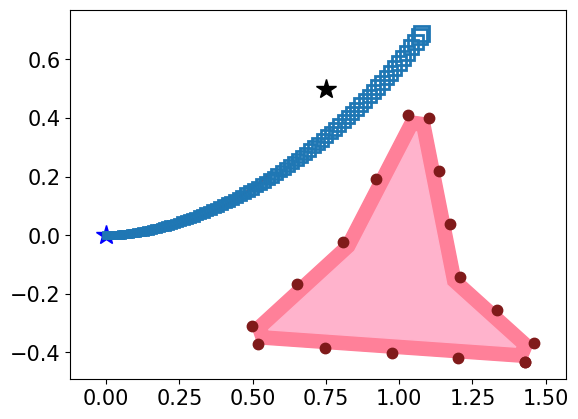

In [62]:
plt.figure(1) # Create a Figure
fig, ax = plt.subplots()

ax.axis('equal') # Set aspect ratio to be equal
ax.tick_params(axis='both', which='major', labelsize=15) # Adjust font size
ax.fill(O_buf[0], O_buf[1], color=[1, 0.5, 0.6]) # Plot the buffered obstacle
ax.fill(O[0], O[1], color=[1, 0.7, 0.8]) # Plot actual obstacle
ax.plot(O_pts[0,:], O_pts[1,:], '.', color=[0.5, 0.1, 0.1], markersize=15) # Plot discretized obstacle
ax.plot(x_des, y_des, 'k*', linewidth=2, markersize=15) # Plot the desired location of the robot
ax.plot(zx0, zy0, 'b*', linewidth=2, markersize=15) # Plot the desired location of the robot
ax.plot(ZXs, ZYs, 'r', linewidth=2, markersize=15) # Plot the desired location of the robot


tfinite = [i for i in range(len(tt))]
# tfinite = [i for i in range(1)]
# print(tfinite)
for t in tfinite:
    print(t)
    ut_t = jnp.array(xx[t]).reshape(1,-1)
    print(ut_t)
    boxes_t = [irx.ut2i(box) for box in ut_t] # Converted to intervals
    print(boxes_t)
    draw_iarrays(ax, boxes_t, zorder=2) # Draw the intervals on ax


plt.show() # Show the plot